### Authors:
#### Danila Rozhevskii, Jiachen Li

### PyTorch Tensors

Reference to guide: https://towardsdatascience.com/pytorch-for-deep-learning-a-quick-guide-for-starters-5b60d2dbb564

In [51]:
import numpy as np
import torch

##### Create a (2D) tensor of size 9 filled with the values 1.0

In [52]:
# could also put zeros() or randn()
t = torch.ones(3,3)
t

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [53]:
t = torch.zeros(3,3)
t

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

##### Type and Size

In [54]:
t = torch.tensor([[1,2,3],[4,5,6]], dtype = float)
t

tensor([[1., 2., 3.],
        [4., 5., 6.]], dtype=torch.float64)

##### Useful functions

In [55]:
t = torch.randn(2,2)
t

tensor([[ 0.1122, -0.3365],
        [-0.2093, -0.1681]])

In [56]:
t.max()

tensor(0.1122)

In [57]:
# item() extracts a standard Python value from a 1D tensor.
t.max().item()

0.11220938712358475

Converting between tensors and Numpy is very simple using torch.from_numpy & torch.numpy().

In [58]:
flat_t = torch.randn(9)
flat_t

tensor([-1.9984, -0.5362, -0.1124, -0.6235,  0.3100,  1.0659, -1.6418,  0.2594,
        -0.6615])

In [59]:
# Tensor.reshape() will work on any tensor and can make a clone if it is needed.
reshape_t = flat_t.reshape(3,3)
reshape_t

tensor([[-1.9984, -0.5362, -0.1124],
        [-0.6235,  0.3100,  1.0659],
        [-1.6418,  0.2594, -0.6615]])

In [60]:
# works only on contiguous tensors and will never copy memory. It will raise an error on a non-contiguous tensor. 
# But you can make the tensor contiguous by calling contiguous() and then you can call view()
view_t = flat_t.view(3,3)
view_t

tensor([[-1.9984, -0.5362, -0.1124],
        [-0.6235,  0.3100,  1.0659],
        [-1.6418,  0.2594, -0.6615]])

### Simple NN Classification Model

Reference for the model: 
https://analyticsindiamag.com/step-by-step-guide-to-build-a-simple-neural-network-in-pytorch-from-scratch/

##### Create a dataset using make_classification under sklearn.datasets which we use in making a classification data set

In [61]:
from sklearn.datasets import make_classification
X, Y = make_classification(
    n_features=4, n_redundant=0, n_informative=3, n_clusters_per_class=2, n_classes=3
)

##### Let’s visualize the dataset

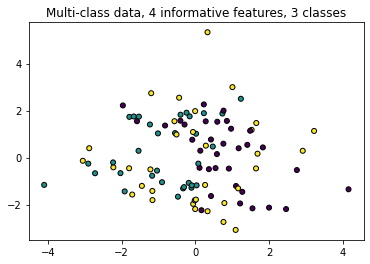

In [62]:
import matplotlib.pyplot as plt
plt.title("Multi-class data, 4 informative features, 3 classes", fontsize="large")
plt.scatter(X[:, 0], X[:, 1], marker="o", c=Y, s=25, edgecolor="k")

##### Before defining model, we split our dataset into tests and train sets

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [64]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((67, 4), (33, 4), (67,), (33,))

##### Define the train data as a PyTorch tensor

In [65]:
import torch
Y_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(np.asarray(Y_test))

##### To use the batches of the dataset we are required to put the data through the Dataloader module of PyTorch

In [66]:
from torch.utils.data import Dataset, DataLoader
class Data(Dataset):
    def __init__(self):
        self.X=torch.from_numpy(X_train)
        self.Y=torch.from_numpy(Y_train)
        self.len=self.X.shape[0]
    def __getitem__(self,index):      
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len
data=Data()
loader=DataLoader(dataset=data,batch_size=64)

##### Check the shape of the split dataset

In [67]:
print(data.X[0:5])
print(data.X.shape)
print(data.Y[0:5])
print(data.Y.shape)

tensor([[ 1.8296,  0.4330,  1.4966, -0.9681],
        [ 1.1589, -1.3114, -0.7350,  0.2567],
        [-0.4399,  2.5494, -1.7501,  1.4258],
        [ 1.6509,  1.4715, -2.1925,  0.5944],
        [-0.4023,  1.8269,  0.6780, -0.0688]], dtype=torch.float64)
torch.Size([67, 4])
tensor([0, 2, 2, 2, 1], dtype=torch.int32)
torch.Size([67])


##### Define the dimensions of the network

In [68]:
input_dim=4     # how many Variables are in the dataset
hidden_dim = 25 # hidden layers
output_dim=3    # number of classes

##### Define class for creating simple networks

In [69]:
import torch.nn as nn
class Net(nn.Module):
    def __init__(self,input,H,output):
        super(Net,self).__init__()
        self.linear1=nn.Linear(input,H)
        self.linear2=nn.Linear(H,output)
 
        
    def forward(self,x):
        x=torch.sigmoid(self.linear1(x))  
        x=self.linear2(x)
        return x

##### Instantiate a classification model instance using the class defined in the last step

In [70]:
clf=Net(input_dim,hidden_dim,output_dim)

In [71]:
print(clf.parameters)

<bound method Module.parameters of Net(
  (linear1): Linear(in_features=4, out_features=25, bias=True)
  (linear2): Linear(in_features=25, out_features=3, bias=True)
)>


##### Define the criterion to calculate gradients of parameters and optimizers to update the parameters

PyTorch has an torch.optim package with various optimization algorithms 
like SGD (Stochastic Gradient Descent), Adam, RMSprop etc .

In [72]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(clf.parameters(), lr=0.1)

##### After defining the criterion and optimizer, we are ready to train our model

In [73]:
learning_rate = 1e-1
loss_list = []
for t in range(1000):
    y_pred = clf(data.X.float())
    loss = criterion(y_pred, data.Y.long())
    loss_list.append(loss.item())
    clf.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in clf.parameters():
            param -= learning_rate * param.grad

In [74]:
data.Y.long()

tensor([0, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 0, 1, 1, 2, 0, 2, 2, 1,
        1, 1, 0, 1, 0, 0, 2, 0, 2, 1, 2, 1, 0, 0, 1, 1, 2, 2, 0, 1, 2, 2, 0, 2,
        2, 1, 2, 0, 1, 2, 0, 0, 2, 1, 1, 1, 0, 0, 1, 0, 2, 2, 1])

##### Optimizing loss curve

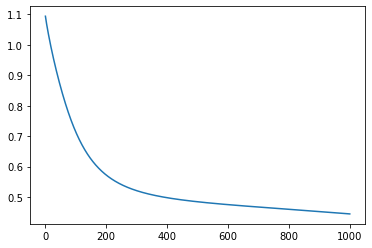

In [75]:
step = np.linspace(0,1000,1000)
plt.plot(step,np.array(loss_list))

##### Defining decision boundaries

(-3.580436957347269, 5.837312633997241)

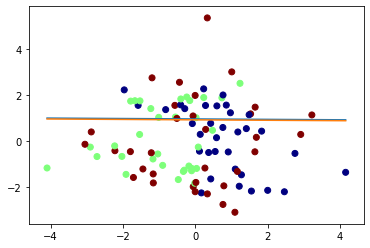

In [76]:
params = list(clf.parameters())
w = params[0].detach().numpy()[0]
b = params[1].detach().numpy()[0]
t= params[3].detach().numpy()[0]
plt.scatter(X[:, 0], X[:, 1], c=Y,cmap='jet')
u = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
plt.plot(u, (0.5-b-w[0]*u)/w[1])
plt.plot(u, (0.5-t-w[0]*u)/w[1])
plt.xlim(X[:, 0].min()-0.5, X[:, 0].max()+0.5)
plt.ylim(X[:, 1].min()-0.5, X[:, 1].max()+0.5)

##### Predictions with the trained neural network

In [77]:
x_val = torch.from_numpy(X_test)
z=clf(x_val.float())
yhat=torch.max(z.data,1)
yhat[1]

tensor([2, 1, 1, 1, 1, 2, 1, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 1, 1, 1,
        2, 2, 0, 2, 1, 1, 2, 1, 2])